In [14]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential, Input, Model, regularizers
from tensorflow.keras.layers import Lambda, Input, Dense, LSTM, RepeatVector, Flatten
from tensorflow.keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import random
from typing import List

from scipy.stats import norm

In [15]:
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [44]:
# network parameters
original_dim = (INPUT_LENGTH - INPUT_EXCESS) * 1
input_shape = (original_dim, 1)
intermediate_dim_0 = 1536
intermediate_dim_1 = 1024
intermediate_dim_2 = 512
intermediate_dim_3 = 128
batch_size = 128
latent_dim = 2
epochs = 100

REGULAR = "reg"
CHIMERIC = "chi"
REPEAT = "rep"
LOW_QUALITY = "loq"

INPUT_LENGTH = 5000
INPUT_THRESHOLD = 1000

INPUT_EXCESS = 2000
NUM_CLASSES = 3


def create_datasets(tsv_input):
    data = pd.read_csv(tsv_input, delimiter="\t")

    # Filter out all low quality reads
    data = data.loc[data.CAT != LOW_QUALITY]

    # Convert sequence string to float array
    data.PTS = data.PTS.apply(string_to_array)
    data.PTS = data.PTS.apply(trim_sequence)

    # Convert labels from strings to ints
    ys = data.CAT.apply(category_to_int).to_numpy()
    xs = np.stack(data.PTS.array)

    encoded_ys = to_categorical(ys, num_classes=NUM_CLASSES)

    print("XS shape: {}".format(xs.shape))
    print("One-hot encoded YS shape: {}".format(encoded_ys.shape))

    train_x, test_x, train_y, test_y = train_test_split(xs, encoded_ys, test_size=0.3)

    return train_x, train_y, test_x, test_y


def trim_sequence(points):
    drop_indexes = random.sample(population=range(0, INPUT_LENGTH), k=INPUT_EXCESS)
    return np.delete(points, drop_indexes, axis=None)


def string_to_array(data):
    data_string = str(data)
    split = data_string.split(',')

    return np.array([float(i) for i in split])


def category_to_int(data):
    category = str(data)
    if category == REGULAR:
        return 0
    elif category == REPEAT:
        return 1
    else:
        return 2

In [45]:
# build encoder
inputs = Input(shape=input_shape, name='encoder_input')
x = LSTM(intermediate_dim_3)(inputs)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [46]:
# Use reparameterization trick to push the sampling out as input
z = Lambda(sampling, name='z')([z_mean, z_log_var])

In [53]:
# instantiate encoder
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 3000, 1)      0                                            
__________________________________________________________________________________________________
lstm_8 (LSTM)                   (None, 128)          66560       encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            258         lstm_8[0][0]                     
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            258         lstm_8[0][0]                     
__________________________________________________________________________________________________
z (Lambda)

In [55]:
# build decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = RepeatVector(INPUT_LENGTH)(latent_inputs)
x = LSTM(intermediate_dim_3)(x)

outputs = Flatten()(x)
outputs = Dense((INPUT_LENGTH - INPUT_EXCESS))(outputs)

In [56]:
# instantiate decoder
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 5000, 2)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               67072     
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3000)              387000    
Total params: 454,072
Trainable params: 454,072
Non-trainable params: 0
_________________________________________________________________


In [57]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [58]:
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)

In [59]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

plot_model(vae, to_file='vae_mlp.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 3000, 1)           0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 67076     
_________________________________________________________________
decoder (Model)              (None, 3000)              454072    
Total params: 521,148
Trainable params: 521,148
Non-trainable params: 0
_________________________________________________________________


In [60]:
def plot_loss(model):
    loss = model.history['loss']
    val_loss = model.history['val_loss']
    plt.figure()
    plt.plot(loss, 'r-', label='Training loss')
    plt.plot(val_loss, 'b-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def plot_decoded(decoded_x, n):
    idxs = range(INPUT_LENGTH)

    fig, ax = plt.subplots(nrows=n, ncols=n, figsize=(15,10))
    fig.patch.set_visible(False)

    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            col.axis('off')
            col.plot(idxs, decoded_x[i * n + j].tolist())
    plt.savefig('grid_generated.png', facecolor='w')
    print("*****   Manifold generation complete   *****")


def plot_confusion_matrix(matrix):
    df_cm = pd.DataFrame(matrix, ["regular", "repeat", "chimeric"], ["regular", "repeat", "chimeric"])
    plt.figure(figsize=(10, 7))
    sb.heatmap(df_cm, annot=True)
    plt.show()

In [61]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
cp = ModelCheckpoint(filepath="vae_lstm.h5", save_best_only=True, verbose=0)

train_x, train_y, test_x, test_y = create_datasets("/floyd/input/overlaps/categorized_400.tsv")
train_x = train_x / np.max(train_x)
test_x = test_x / np.max(test_x)

train_x = np.expand_dims(train_x, axis=2)
#train_y = np.expand_dims(train_y, axis=2)
test_x = np.expand_dims(test_x, axis=2)
#test_y = np.expand_dims(test_y, axis=2)
print(train_x.shape)
print(train_y.shape)

history = vae.fit(train_x, epochs=epochs, batch_size=batch_size, validation_data=(test_x, None), callbacks=[es, cp])
plot_loss(history)

XS shape: (330, 3000)
One-hot encoded YS shape: (330, 3)
(231, 3000, 1)
(231, 3)
Train on 231 samples, validate on 99 samples
Epoch 1/100


InvalidArgumentError: Incompatible shapes: [128,3000] vs. [128,3000,1]
	 [[{{node sub_12}} = Sub[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/sub_12_grad/Reshape"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](decoder_4/dense_5/BiasAdd, _arg_encoder_input_4_0_0/_319)]]
	 [[{{node loss_4/add/_357}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_5075_loss_4/add", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [14]:
# Train SVM classifier on training labels \& training latent samples
train_z, _, _ = encoder.predict(train_x, batch_size=batch_size)
print("Training Z shape: {}".format(train_z.shape))

svm = SVC(kernel='rbf')
svm.fit(train_z, train_y.argmax(axis=1))

Training Z shape: (280, 2)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
n = 30  # how many overlaps we will display
u_grid = np.dstack(np.meshgrid(np.linspace(0.01, 0.99, n), np.linspace(0.01, 0.99, n)))
z_grid = norm.ppf(u_grid)
 
recons_x = decoder.predict(z_grid.reshape(n * n, 2))
print(recons_x.shape)

plot_decoded(recons_x, n)

(900, 5000)
*****   Manifold generation complete   *****


ValueError: list.remove(x): x not in list

<Figure size 1080x720 with 900 Axes>

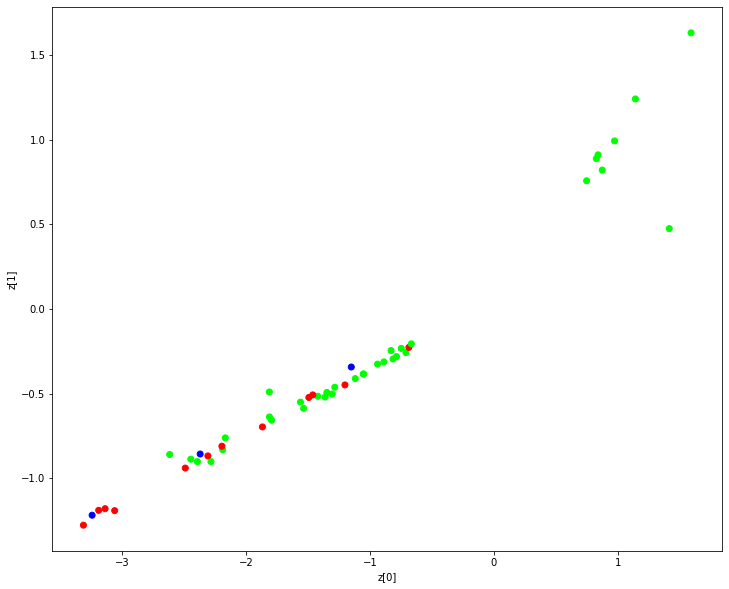

[1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0
 1 0 1 1 1 1 1 1 1 1 0 1 0]


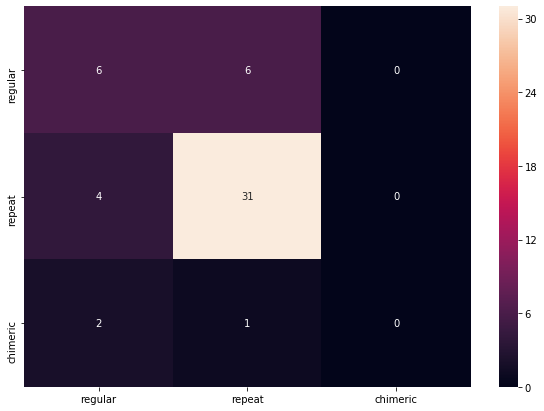

             precision    recall  f1-score   support

          0       0.50      0.50      0.50        12
          1       0.82      0.89      0.85        35
          2       0.00      0.00      0.00         3

avg / total       0.69      0.74      0.71        50



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
# Test classifier
test_z, _, _ = encoder.predict(test_x, batch_size=batch_size)

plt.figure(figsize=(12, 10))
plt.scatter(test_z[:, 0], test_z[:, 1], c=test_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()


pred_y = svm.predict(test_z)
print(pred_y)

matrix = metrics.confusion_matrix(test_y.argmax(axis=1), pred_y)
plot_confusion_matrix(matrix)

print(metrics.classification_report(test_y.argmax(axis=1), pred_y))